# Where Are The Voters?
Tynan Challenor from Stanford University published their finding in a paper called "Predicting Votes From Census Data". They gathered data from a survey given by Census that took place after the 2016 election, and used Logistic Regression, Support Vector Machine, and Naive Bayes models to predict whether or not a person is likely to vote. This inspired me to see if I could do the same, but rather than predicting an individual's likeliness to vote, I want to predict whether or not a county will have a low voter turnout.

In [1]:
## Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import f1_score, precision_score, classification_report, recall_score, accuracy_score, roc_curve, auc, roc_auc_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

I gathered my data from two different sources--one from the 2016 presidential election, which includes most of my features, and one from the 2018 midterm election.

In [2]:
## Election 2018 dataset
elect18 = pd.read_csv('/home/xristsos/Documents/2016 election/national-files/us-senate-wide.csv')
elect18 = pd.DataFrame(elect18[['state','county','total.votes']])

In [3]:
## Cleaning 2018 data
elect18.columns = ['state','county','total_votes_senate18']
elect18.county = elect18.county + ' County'
elect18.sort_values('county',inplace=True)
elect18.set_index('county',inplace=True)
elect18.head()

,state,total_votes_senate18
county,,
Abbot County,ME,307
Abington County,MA,7337
Accomack County,VA,12745
Acton County,MA,11024
Acton County,ME,1209


In [4]:
##Election 2016 dataset
elect16 = pd.read_json('/home/xristsos/Downloads/usa-2016-presidential-election-by-county.json')
## Converting all the dictionaries in Fields columns to one data frame
elect16 = pd.DataFrame(data=[x for x in elect16['fields']])

##Create copy for GeoPandas
geo_df = elect16.copy()

In [5]:
## Cleaning 2016 data
elect16.drop(['state','geo_shape','temp_bins'],axis=1,inplace=True)
elect16.rename(columns={'st':'state'},inplace=True)
elect16.county = [x.split(', ') for x in elect16.county]
elect16.county = [x[0] for x in elect16.county]
elect16.set_index('county',inplace=True)

##Fill and remove missing data
elect16.teen_births.fillna(elect16.teen_births.median(),inplace=True)
def remove_cols(df):
    for col in df.columns:
        if '16' in col:
            df.drop(col,axis=1,inplace=True)
        elif df[col].isna().sum() > 40:
            df.drop(col,axis=1,inplace=True)
remove_cols(elect16)

In [6]:
## Describe population data
elect16.total_population.describe()

count    3.143000e+03
mean     9.707373e+04
std      3.110648e+05
min      8.100000e+01
25%      1.102850e+04
50%      2.563100e+04
75%      6.589200e+04
max      9.801950e+06
Name: total_population, dtype: float64

In [7]:
## Adding new columns
##create a columnn for the percentage of voter turnout
elect16['voter_percent'] = elect16['votes'] / elect16['total_population']
## ranks the size of county from 1 to 5
scores = []
for i in elect16.total_population:
    if i <= 5000:
        scores.append(1)
    elif i > 5000 and i <= 15000:
        scores.append(2)
    elif i > 15000 and i <= 30000:
        scores.append(3)
    elif i > 30000 and i <= 50000:
        scores.append(4)
    elif i > 50000:
        scores.append(5)
elect16['size_rank'] = scores
elect16.voter_percent.fillna(elect16.voter_percent.mean(),inplace=True)

In [8]:
## Merge the two dataframes by state and county
df = pd.merge(elect18,elect16,how='inner',on=['county','state'])
df.drop_duplicates(inplace=True)
df.head(10)

,state,total_votes_senate18,acfs,adult_obesity,adults_65_and_older_living_in_poverty,african_american_population,amerindian,asian,asian_american_population,at_least_bachelor_s_degree,...,total12,total_population,unemployment,uninsured,votes,white,white_asian,white_not_latino_population,voter_percent,size_rank
county,,,,,,,,,,,,,,,,,,,,,
Accomack County,VA,12745,1.577735e-05,0.355,16.50,28.35,0.20,0.40,0.40,18.0,...,16051.0,35843,0.069,0.204,15755.0,61.05,61.45,61.05,0.439556,4
Adair County,MO,8695,1.127980e-04,0.305,13.40,1.50,0.30,1.50,1.50,25.5,...,10126.0,25204,0.060,0.184,10137.0,93.00,94.50,93.00,0.402198,3
Adams County,MS,10760,1.345093e-04,0.361,20.05,54.55,0.25,0.25,0.25,19.3,...,15447.0,31886,0.094,0.217,12214.0,40.40,40.65,40.40,0.383052,4
Adams County,MS,10826,1.345093e-04,0.361,20.05,54.55,0.25,0.25,0.25,19.3,...,15447.0,31886,0.094,0.217,12214.0,40.40,40.65,40.40,0.383052,4
Adams County,WA,4232,1.508938e-04,0.373,13.85,0.25,0.35,0.30,0.30,13.4,...,4793.0,17878,0.088,0.248,4081.0,40.85,41.15,40.85,0.228269,3
Adams County,WI,9399,4.084924e-05,0.302,6.40,3.00,0.85,0.55,0.55,10.8,...,10287.0,20637,0.099,0.122,10107.0,91.25,91.80,91.25,0.489751,3
Adams County,IN,11146,4.519606e-05,0.304,8.05,0.30,0.15,0.20,0.20,12.2,...,13011.0,34171,0.078,0.189,13039.0,94.85,95.05,94.85,0.381581,4
Adams County,PA,39102,2.454162e-06,0.283,7.05,1.50,0.10,0.70,0.70,18.5,...,42457.0,101209,0.066,0.125,47138.0,90.70,91.40,90.70,0.465749,5
Adams County,OH,8643,9.187509e-07,0.307,16.30,0.35,0.35,0.10,0.10,10.7,...,11118.0,28346,0.108,0.164,11063.0,96.90,97.00,96.90,0.390284,3


In [9]:
## Take the percent of voters from the midterm election and take the average turnout from the two elections
df['2018_vote_percent'] = df.total_votes_senate18 / df.total_population
df1 = pd.DataFrame(df.drop(['voter_percent','2018_vote_percent'],axis=1))
df1['avg_percent'] = (df['voter_percent'] + df['2018_vote_percent']) / 2

Now that I have all the data in one dataframe, but before I start exploring, I have to define my target variable "low voter turnout". It was difficult for me to decide, because average national voter turnout has been consistently around 45%, which is already low. For this model to be applicable for campaign purposes, I chose to define everything below 38% as a low turnout.

In [10]:
df1.avg_percent.describe()

count    1973.000000
mean        0.413598
std         0.088057
min         0.184366
25%         0.356250
50%         0.407813
75%         0.468746
max         0.980144
Name: avg_percent, dtype: float64

In [11]:
df1['low_turnout'] = [1 if x <= .38 else 0 for x in df1['avg_percent']]
## Remove outliers
df1 = pd.DataFrame(df1[df1['avg_percent']<.9])
target = df1['low_turnout']

In [12]:
features = pd.DataFrame(df1[['gini_coefficient','asian_american_population','african_american_population',
                      'uninsured','production_transportation_and_material_moving_occupations','size_rank',
                      'poverty_rate_below_federal_poverty_threshold','construction_extraction_maintenance_and_repair_occupations',
                      'less_than_high_school','at_least_bachelor_s_degree','unemployment',
                      'latino_population','management_professional_and_related_occupations','native_american_population',
                      'sales_and_office_occupations','white_not_latino_population']])

As a consequence of the turnout definition, my target variable is unbalanced. I will deal with this during model selection.

# Exploratory Data Analysis

In [13]:
## Checking for correlated features
features.corr()

,gini_coefficient,asian_american_population,african_american_population,uninsured,production_transportation_and_material_moving_occupations,size_rank,poverty_rate_below_federal_poverty_threshold,construction_extraction_maintenance_and_repair_occupations,less_than_high_school,at_least_bachelor_s_degree,unemployment,latino_population,management_professional_and_related_occupations,native_american_population,sales_and_office_occupations,white_not_latino_population
gini_coefficient,1.000000,0.089158,0.381457,0.353263,-0.179492,0.070471,0.556957,-0.082660,0.348280,0.120154,0.215396,0.207180,0.028199,0.052239,0.082006,-0.436856
asian_american_population,0.089158,1.000000,0.006158,-0.157307,-0.281700,0.337948,-0.172542,-0.273966,-0.168422,0.500096,0.015776,0.129817,0.375532,-0.047370,0.205603,-0.262770
african_american_population,0.381457,0.006158,1.000000,0.187877,0.086845,0.051340,0.478083,-0.064769,0.369127,-0.059646,0.366350,-0.098978,-0.132382,-0.085353,0.068574,-0.568028
uninsured,0.353263,-0.157307,0.187877,1.000000,-0.051535,-0.290476,0.539317,0.352528,0.617461,-0.346462,0.163972,0.526012,-0.301912,0.091238,-0.204306,-0.516142
production_transportation_and_material_moving_occupations,-0.179492,-0.281700,0.086845,-0.051535,1.000000,-0.094792,0.160969,0.037513,0.308996,-0.578239,0.205454,-0.228216,-0.637968,-0.118834,-0.229068,0.198587
size_rank,0.070471,0.337948,0.051340,-0.290476,-0.094792,1.000000,-0.168043,-0.293166,-0.205300,0.428321,0.191825,0.017355,0.159406,-0.091815,0.590630,-0.081014
poverty_rate_below_federal_poverty_threshold,0.556957,-0.172542,0.478083,0.539317,0.160969,-0.168043,1.000000,0.103282,0.692843,-0.407777,0.446138,0.232308,-0.423491,0.194726,-0.149827,-0.519825
construction_extraction_maintenance_and_repair_occupations,-0.082660,-0.273966,-0.064769,0.352528,0.037513,-0.293166,0.103282,1.000000,0.311388,-0.447066,0.031624,0.115434,-0.452590,0.021452,-0.234052,-0.006793
less_than_high_school,0.348280,-0.168422,0.369127,0.617461,0.308996,-0.205300,0.692843,0.311388,1.000000,-0.585945,0.374371,0.434190,-0.567013,-0.008438,-0.205701,-0.534247
at_least_bachelor_s_degree,0.120154,0.500096,-0.059646,-0.346462,-0.578239,0.428321,-0.407777,-0.447066,-0.585945,1.000000,-0.265758,-0.022668,0.790432,-0.054828,0.327751,-0.008115


In [16]:
###Calculate PCA and plot results
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
components = pca.fit_transform(features)

In [17]:
components

array([[ 2.19521464e+01,  1.73207901e+01,  1.96819573e+00,
        -3.25071498e+00,  2.68087544e+00],
       [-1.51432713e+01, -9.11836415e-01,  5.83124387e+00,
         2.55037722e+00, -1.26014412e+01],
       [ 4.62607334e+01,  4.12161486e+01,  1.12316926e+01,
        -2.20985922e+00, -2.81051188e+00],
       ...,
       [ 5.77270132e+01, -3.10900923e+01, -1.14596329e+01,
        -3.03025922e+00,  1.81503934e-02],
       [ 1.00682176e+02, -4.79829323e+01, -2.45168433e+01,
        -3.45497455e+00, -1.40010404e+01],
       [ 1.02084834e+02, -4.75910057e+01, -2.78939669e+01,
        -3.70775723e+00, -1.02900766e+01]])

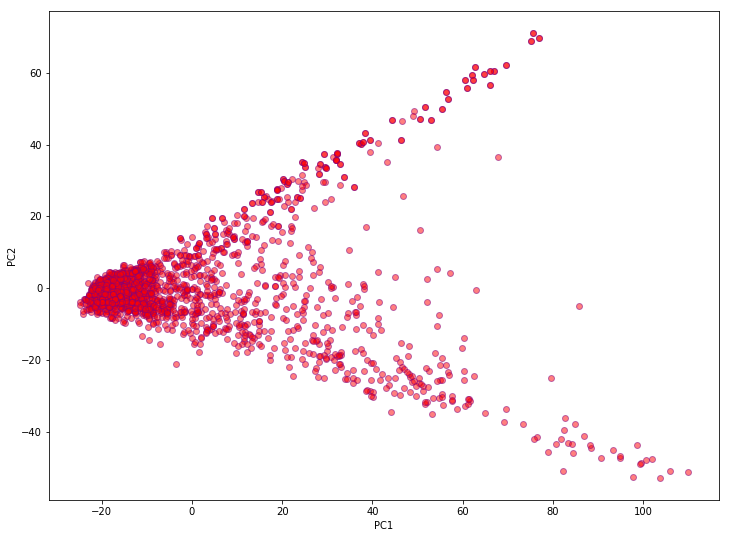

In [18]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1,1,1)
ax.set(xlabel='PC1',ylabel='PC2')
ax.scatter(components[:,0],components[:,1], marker='o',c='red',edgecolors='purple',alpha=.5)
# plt.savefig('scatter_pca.png')

Text(0, 0.5, 'Explained variance ratio')

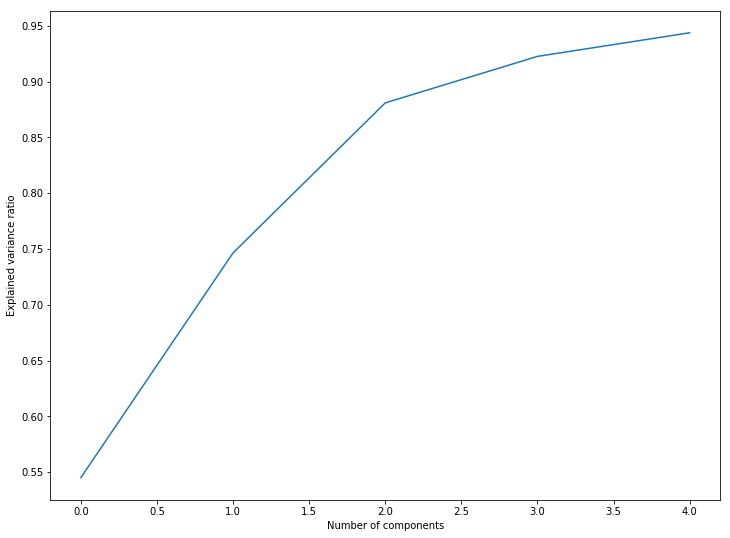

In [19]:
fig = plt.figure(figsize=(12,9))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
# plt.savefig('explained_vr.png')

# Model Selection

In [20]:
X = features
xTrain,xTest,yTrain,yTest = train_test_split(X,target,test_size=.25)

In [21]:
## Helper function that calculates scores for models
def calc_scores(yTest,yPred):
    print('Precision: ', precision_score(yTest,yPred))
    print('F1: ', f1_score(yTest,yPred))
    print('Accuracy: ', accuracy_score(yTest,yPred))
    print('Recall: ', recall_score(yTest,yPred))
    falseP,trueP,thresholds = roc_curve(yTest,yPred)
    roc_auc = auc(falseP,trueP)
    print('ROC_AUC: ', roc_auc)
    print(confusion_matrix(yTest,yPred))

# Random Forest

In [22]:
def grid_search(xTrain,xTest,yTrain,yTest):
    gs = GridSearchCV(estimator=RandomForestClassifier(),
                     param_grid={'max_depth': [3,8],
                                 'n_estimators': (25,50,75,100,500,1000),
                                 'max_features': (4,6,8)},
                     cv=4,n_jobs=-1,scoring='balanced_accuracy')
    model = gs.fit(xTrain,yTrain)
    print(f'Best score: {model.best_score_}')
    print(f'Best parms: {model.best_params_}')

In [23]:
grid_search(xTrain,xTest,yTrain,yTest)

Best score: 0.7938280301435822
Best parms: {'max_depth': 8, 'max_features': 8, 'n_estimators': 50}


In [24]:
#Random Forest
rf = RandomForestClassifier(n_estimators=1000,max_depth=8,max_features=4)
rf.fit(xTrain,yTrain)
rf_y = rf.predict(xTest)
print('Random Forest: ')
calc_scores(yTest,rf_y)

Random Forest: 
Precision:  0.8058823529411765
F1:  0.7740112994350282
Accuracy:  0.8377281947261663
Recall:  0.7445652173913043
ROC_AUC:  0.818884550443225
[[276  33]
 [ 47 137]]


# Logistic Regression

In [25]:
lr1 = LogisticRegression()
lr1.fit(xTrain,yTrain)
lr1_y = lr1.predict(xTest)
print('Logistic Regression: ')
calc_scores(yTest,lr1_y)

Logistic Regression: 
Precision:  0.712707182320442
F1:  0.7068493150684931
Accuracy:  0.7829614604462475
Recall:  0.7010869565217391
ROC_AUC:  0.7664010834388632
[[257  52]
 [ 55 129]]


/home/xristsos/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# XGBoost

In [26]:
def boost_search(xTrain,xTest,yTrain,yTest):
    gs = GridSearchCV(estimator=XGBClassifier(),
                     param_grid={'max_depth': [3,8],
                                 'n_estimators': (25,50,75,100,500,1000),
                                 'max_features': (4,6,8),
                                 'eta': (.1,.07,.05,.03,.01),
                                 'min_child_weight': (1,2),
                                 'sub_sample': (.3,.5,.7),
                                 'min_samples_split': (.4,.5,.6,.7)},
                     cv=4,n_jobs=-1,scoring='balanced_accuracy')
    model = gs.fit(xTrain,yTrain)
    print(f'Best score: {model.best_score_}')
    print(f'Best parms: {model.best_params_}')

In [ ]:
boost_search(xTrain,xTest,yTrain,yTest)

In [27]:
xg = XGBClassifier(silent=0,eta=.1,min_child_weight=1,sub_sample=.3,eval_metric='auc',n_estimators=1000,
                    max_depth=8,min_samples_split=.4,max_features=4)
xg.fit(xTrain,yTrain)
xg_y = xg.predict(xTest)
print('XGBoost:')
calc_scores(yTest,xg_y)

XGBoost:
Precision:  0.8
F1:  0.7912087912087912
Accuracy:  0.845841784989858
Recall:  0.782608695652174
ROC_AUC:  0.8330519206416209
[[273  36]
 [ 40 144]]


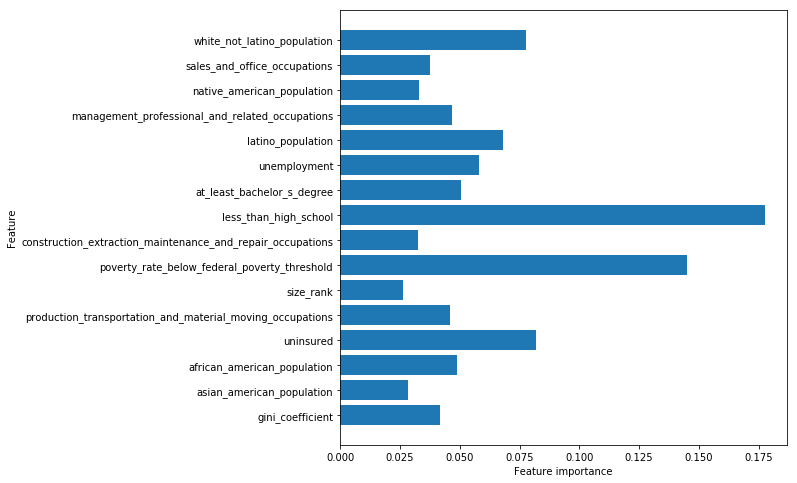

In [28]:
def plot_feature_importances(model,X_train):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(rf,xTrain)

# The Final Model!

In [30]:
xTrain,xTest,yTrain,yTest = train_test_split(X,target, train_size=.2)

/home/xristsos/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [33]:
xg.fit(xTrain,yTrain)
final_pred = xg.predict(xTest)
print('XGBoost:')
calc_scores(yTest,final_pred)

XGBoost:
Precision:  0.7832699619771863
F1:  0.7298494242692649
Accuracy:  0.8064720812182741
Recall:  0.6832504145936982
ROC_AUC:  0.7830435012331287
[[859 114]
 [191 412]]


# Folium / GeoPandas stuff idk how to use yet

In [ ]:
geo_df = pd.DataFrame(geo_df[['county','geo_shape']])

In [ ]:
geo_df.county = [x.split(', ') for x in geo_df.county]
geo_df['state'] = [x[1] for x in geo_df.county]
geo_df.county = [x[0] for x in geo_df.county]
geo_df.rename(columns={'geo_shape':'geometry'},inplace=True)

In [ ]:
geo_df.head()

In [ ]:
import geopandas

In [ ]:
geo = geopandas.GeoSeries(geo_df['geometry'])

In [ ]:
m = geopandas.GeoDataFrame(geo_df)

In [ ]:
geo[0].values()